[View in Colaboratory](https://colab.research.google.com/github/shimo8810/machine_intelligence/blob/master/deep_learning/colab/celeb_A.ipynb)

In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0  21888      0 --:--:-- --:--:-- --:--:-- 21888
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-9-2 is already the newest version (9.2.148-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
+ pip install -q cupy-cuda92  chainer 
+ set +ex
Installation succeeded!


In [0]:
from pathlib import Path
from google.colab import drive
from tqdm import tqdm

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import chainer
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence
from chainer import training
from chainer.training import extensions
from chainer.dataset import dataset_mixin

In [3]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


## Parameter

In [0]:
epoch = 100
n_ch = 32
n_latent = 100
batchsize = 512

out_dir = 'vae_result'

## Dataset

Google Driveのディレクトリをマウント

In [5]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


データセットファイをを解凍

In [6]:
!unzip -qq 'gdrive/My Drive/Data/celebA/test_proc.zip'
!unzip -qq 'gdrive/My Drive/Data/celebA/train_proc.zip'

replace test_proc/186018.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### Dataset

In [0]:
class CelebADataset(dataset_mixin.DatasetMixin):
    def __init__(self, data_path):
        self.data = []
        for image_path in tqdm(data_path.glob('*.jpg')):
            image = np.array(Image.open(image_path)) \
                .astype('f').transpose(2, 0, 1) / 255.
            self.data.append(image)
        
    def __len__(self):
        return len(self.data)

    def get_example(self, i):
        return self.data[i]

## Network

In [0]:
class ConvBNR(chainer.Chain):
    """
    Convolution -> (BatchNormalization) -> (Dropout) -> ReLU
    """
    def __init__(self, ch_in, ch_out, use_bn=True, act=F.relu, use_dp=False):
        self.use_bn = use_bn
        self.act = act
        self.use_dp = use_dp

        init_w = chainer.initializers.HeNormal()

        super(ConvBNR, self).__init__()

        with self.init_scope():
            self.conv = L.Convolution2D(
                ch_in, ch_out, ksize=4, stride=2, pad=1, initialW=init_w)

            if self.use_bn:
                self.bn = L.BatchNormalization(ch_out)

    def forward(self, x):
        h = self.conv(x)
        if self.use_bn:
            h = self.bn(h)
        if self.use_dp:
            h = F.dropout(h)
        if self.act is not None:
            h = self.act(h)
        return h

class UpConvBNR(chainer.Chain):
    """
    DeConvolution -> (BatchNormalization) -> (Dropout) -> ReLU
    """
    def __init__(self, ch_in, ch_out, use_bn=True, act=F.relu, use_dp=False):
        self.use_bn = use_bn
        self.act = act
        self.use_dp = use_dp

        init_w = chainer.initializers.HeNormal()

        super(UpConvBNR, self).__init__()

        with self.init_scope():
            self.conv = L.Deconvolution2D(
                ch_in, ch_out, ksize=4, stride=2, pad=1, initialW=init_w)

            if self.use_bn:
                self.bn = L.BatchNormalization(ch_out)

    def forward(self, x):
        h = self.conv(x)
        if self.use_bn:
            h = self.bn(h)
        if self.use_dp:
            h = F.dropout(h)
        if self.act is not None:
            h = self.act(h)
        return h

class VAE(chainer.Chain):
    def __init__(self, n_ch, n_latent, size):
        self.z_ch = n_ch * (2**4)
        self.z_size = size // (2**4)
        init_w = chainer.initializers.HeNormal()
        
        super(VAE, self).__init__()
        with self.init_scope():
            # encoder
            self.enc_conv0 = ConvBNR(   3,   n_ch, act=F.leaky_relu)  #( 3, 64) -> (32, 32)
            self.enc_conv1 = ConvBNR(1*n_ch, 2*n_ch, act=F.leaky_relu)#(32, 32) -> (64, 16)
            self.enc_conv2 = ConvBNR(2*n_ch, 4*n_ch, act=F.leaky_relu)#(64, 16) -> (128, 8)
            self.enc_conv3 = ConvBNR(4*n_ch, 8*n_ch, act=F.leaky_relu)#(128, 8) -> (256, 4)
            self.enc_fc4_mu = L.Linear(None, n_latent)
            self.enc_fc4_ln_var = L.Linear(None, n_latent)
            
            # decoder
            self.dec_fc0 = L.Linear(n_latent, self.z_ch * self.z_size ** 2)
            self.dec_conv1 = UpConvBNR(None, 4*n_ch, act=F.leaky_relu)  #(256, 4) -> (128, 8)
            self.dec_conv2 = UpConvBNR(4*n_ch, 2*n_ch, act=F.leaky_relu)#(128, 8) -> (64, 16)
            self.dec_conv3 = UpConvBNR(2*n_ch, 1*n_ch, act=F.leaky_relu)#(64, 16) -> (32, 32)
            self.dec_conv4 = UpConvBNR(1*n_ch,n_ch//2, act=F.leaky_relu)#(32, 32) -> (16, 64)
            self.dec_conv5 = L.Convolution2D(
                None, 3, ksize=1, stride=1, initialW=init_w)#(16, 64) -> ( 3, 64)

    def encode(self, x):
        h = F.leaky_relu(self.enc_conv0(x))
        h = self.enc_conv1(h)
        h = self.enc_conv2(h)
        h = self.enc_conv3(h)
        mu = self.enc_fc4_mu(h)
        ln_var = self.enc_fc4_ln_var(h)
        return mu, ln_var
    
    def decode(self, z, sig=True):
        h = F.leaky_relu(self.dec_fc0(z))
        h = F.reshape(h, (z.shape[0], self.z_ch, self.z_size, self.z_size))
        h = self.dec_conv1(h)
        h = self.dec_conv2(h)
        h = self.dec_conv3(h)
        h = self.dec_conv4(h)
        h = self.dec_conv5(h)
        if sig:
            return F.sigmoid(h)
        else:
            return h
        
    def forward(self, x, sig=True):
        return self.decode(self.encode(x)[0], sig)
        
    def get_loss_func(self, beta=1.0, k=1):
        def lf(x):
            mu, ln_var = self.encode(x)
            batchsize = len(mu)
            # reconstruction loss
            rec_loss = 0
            for l in range(k):
                z = F.gaussian(mu, ln_var)
                rec_loss += F.bernoulli_nll(x, self.decode(z, sig=False)) \
                    / (k * batchsize)
            self.rec_loss = rec_loss
            self.loss = self.rec_loss + \
                beta * gaussian_kl_divergence(mu, ln_var) / batchsize
            chainer.report(
                {'rec_loss': rec_loss, 'loss': self.loss}, observer=self)
            return self.loss
        return lf

In [9]:
train = CelebADataset(Path('train_proc'))
test = CelebADataset(Path('test_proc'))

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize,
                repeat=False, shuffle=False)

162770it [01:22, 1976.85it/s]
19962it [00:20, 970.02it/s] 


In [0]:
model = VAE(n_ch=n_ch, n_latent=n_latent, size=64)

# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

# Set up an updater
updater = training.updaters.StandardUpdater(
        train_iter, optimizer,
        device=0, loss_func=model.get_loss_func())

# Set up a Trainer
trainer = training.Trainer(updater, (epoch, 'epoch'), out=out_dir)

# Set up Updater Extentions
trainer.extend(extensions.Evaluator(test_iter, model, device=0,
                                    eval_func=model.get_loss_func(k=10)))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.snapshot(
    filename='snapshot_epoch-{.updater.epoch}'), trigger=(10, 'epoch'))
trainer.extend(extensions.snapshot_object(
    model, filename='model_epoch-{.updater.epoch}'), trigger=(10, 'epoch'))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))

In [11]:
trainer.run()

epoch       main/loss   validation/main/loss  main/rec_loss  validation/main/rec_loss  elapsed_time
1           6755.62     6485.25               6651.29        6372.95                   141.556       
2           6485.6      6431.1                6374.26        6316.22                   282.24        
3           6448.98     6402.62               6336.31        6290.14                   422.912       
4           6432.79     6388.78               6319.66        6276.35                   563.574       
5           6421.14     6380.14               6307.96        6267.37                   704.27        
6           6413.01     6374.92               6299.93        6262.51                   844.911       
7           6407.5      6370.91               6294.54        6257.18                   985.602       
8           6402.16     6366.16               6289.3         6253.84                   1126.31       
9           6398.41     6360.23               6285.69        6247.69                

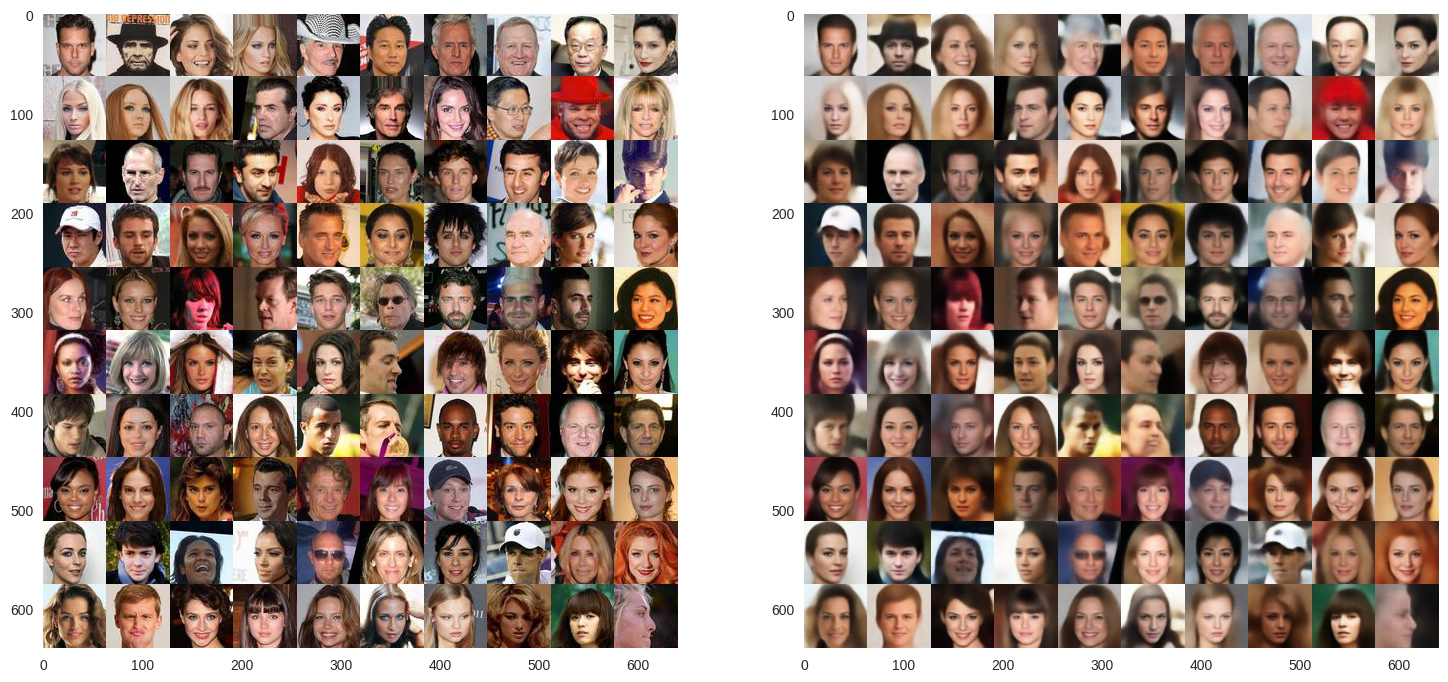

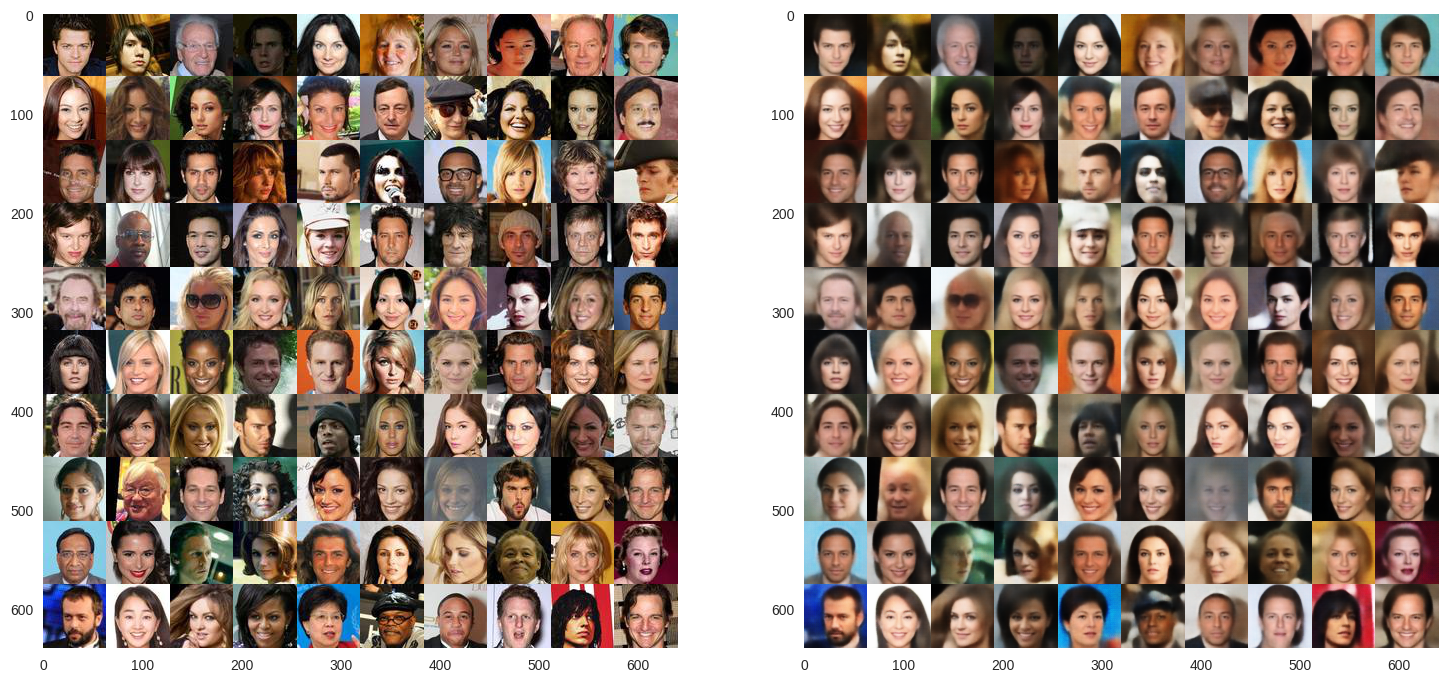

In [12]:
model.to_cpu()
# train data
x_in = np.array(train[:100])
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x_out = np.clip(model(x_in).data * 255, 0, 255).astype(np.uint8)

fig, ax = plt.subplots(1, 2, figsize=(18, 9), dpi=100)
for ai, x in zip(ax.flatten(), (x_in, x_out)):
    x = x.reshape(10, 10, 3, 64, 64).transpose(0, 3, 1, 4, 2).reshape(10*64, 10*64, 3)
    ai.grid(False)
    ai.imshow(x)

fig.savefig(str(Path(out_dir).joinpath('train_reconstructed_image.png')))

# test data
x_in = np.array(test[:100])
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x_out = np.clip(model(x_in).data * 255, 0, 255).astype(np.uint8)

fig, ax = plt.subplots(1, 2, figsize=(18, 9), dpi=100)
for ai, x in zip(ax.flatten(), (x_in, x_out)):
    x = x.reshape(10, 10, 3, 64, 64).transpose(0, 3, 1, 4, 2).reshape(10*64, 10*64, 3)
    ai.grid(False)
    ai.imshow(x)
    
fig.savefig(str(Path(out_dir).joinpath('test_reconstructed_image.png')))

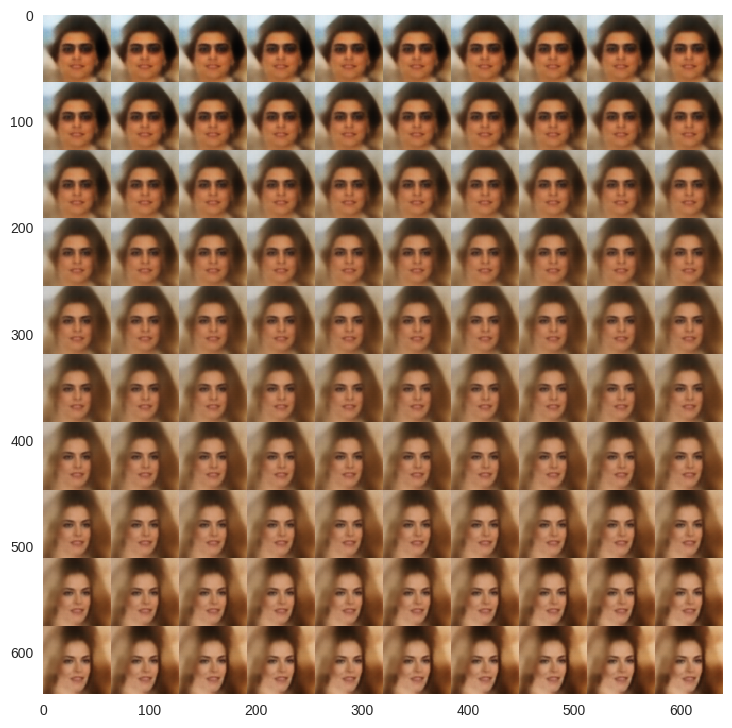

In [13]:
z1, z2 = np.random.normal(0, 1, (2, 100))
z = z1 + np.kron(np.linspace(0, 1, 100).reshape(100, 1), (z2 - z1))
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x = model.decode(z.astype(np.float32)).data

plt.figure(figsize=(9, 9), dpi=100)
plt.imshow(x.reshape(10, 10, 3, 64, 64).transpose(0, 3, 1, 4, 2).reshape(10*64, 10*64, 3))
plt.grid(False)
plt.savefig(str(Path(out_dir).joinpath('sampled_image.png')))
plt.show()